Variables of filenames

In [10]:
#PLAINTREE FILES NAMES
directory='/Users/julnow/gsi/cbm/ML/JupyterNotebooks/'
signalFileName = directory + 'PlainTree_100kSign.root'
backgroundFileName = directory + 'PlainTree_15kBckgr_URQMD.root'

# Importing the Libraries

**Numpy** is a powerful library that makes working with python more efficient, so we will import it and use it as np in the code. **Pandas** is another useful library that is built on numpy and has two great objects *series* and *dataframework*. Pandas works great for *data ingestion* and also has *data visualization* features. **Matplotlib** and **Seaborn** come handy in plotting and visualizing the data. From **Hipe4ml** we import **TreeHandler** and with the help of this function we will import our *Analysis Tree* to our notebook. We will also need some functions of **Scipy** for fittintg. **Seaborn** will be used to prepare the heatmap of the correlations of all variables. **gc** - garbage collector will get rid of unnecessary data; **os** will create the folder for graphs.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sn
#from hipe4ml.tree_handler import TreeHandler
#from hipe4ml import plot_utils
from matplotlib.patches import ConnectionPatch
from scipy.stats import binned_statistic as b_s
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from sklearn import datasets, linear_model
import gc
import os

To import the root files with simulated data as PlainTrees into Panda's dataframes format we use the function from **CBM_ML_LAMBDA_LIBRARY** prepared by Shahid.

In [3]:
#Shahid's library for importing roottrees
#%%capture
!git clone https://github.com/shahidzk1/CBM_ML_Lambda_Library.git
%cd CBM_ML_Lambda_Library
!git pull origin main
!pip install -r requirements.txt
!python setup.py install
from CBM_ML import tree_importer, plot_tools, KFPF_lambda_cuts

fatal: destination path 'CBM_ML_Lambda_Library' already exists and is not an empty directory.
/Users/julnow/gsi/cbm/ML/JupyterNotebooks/CBM_ML_Lambda_Library
hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.
From https://github.com/shahidzk1/CBM_ML_Lambda_Library
 * branch            main       -> FETCH_HEAD
Updating 05397b7..7e5f89d
error: Your local changes to the following files would be overwritten by

With the help of a selection cut, we select only signal candidates and background candidates from their respective data sets. Another selection cut chooses K-short candidates only in the $\pm 5\sigma$ region around the mean of the lambda mass peak. Similarly, we select the background candidates outside this $\pm 5\sigma$ region.

In [5]:
#CUTS FOR MASS SELECTION
#5 sigma region for signal
lower5SigmaCutSign = 0.43485
upper5SigmaCutSign = 0.56135
#mean invariant mass
invMass = 0.4981
# "5sigma" (not acutal 5 sigma) region for background
lower5SigmaCutBckgr = 0.1
upper5SigmaCutBckgr = 2

In [11]:
# We import three root files into our jupyter notebook
#sign - before cleaning but after 5sigma seletion, signal - cleaned
#so that we dont have to reimport everything with each change
sign = tree_importer.tree_importer(signalFileName,'PlainTree',7)

# We only select lambda candidates in the 5 sigma region around the kaon mass peak
#we preserve the cleaned dataframe with a changed name
sign = sign[(sign['Candidates_generation']==1) & (sign['Candidates_mass']>lower5SigmaCutSign) & (sign['Candidates_mass']<upper5SigmaCutSign)]

# Similarly for the background, we select background candidates which are not in the 5 sigma region of the kaon peak
bckgr = tree_importer.tree_importer(backgroundFileName,'PlainTree',7)
#we preserve the cleaned dataframe with a changed name
bckgr = bckgr[(bckgr['Candidates_generation'] < 1)
                 & ((bckgr['Candidates_mass'] > lower5SigmaCutBckgr)
                 & (bckgr['Candidates_mass'] < lower5SigmaCutSign) | (bckgr['Candidates_mass']>upper5SigmaCutSign) 
                    & (bckgr['Candidates_mass'] < upper5SigmaCutBckgr))]

#Also call the garbage collector of python to collect unused items to free memory
gc.collect()

2506

As the PlainTrees contain some unnecessary prefixes in the column names, we'll remove them. We also drop columns not used in the analysis. To prepare the graphs, we prepare the names of the columns and the axis labels in the LaTex format.

In [12]:
#we remove name prefixes 'Candidates'
bckgr.columns = bckgr.columns.str.replace('Candidates_', '')
bckgr.columns = bckgr.columns.str.replace('_', '')
sign.columns = sign.columns.str.replace('Candidates_', '')
sign.columns = sign.columns.str.replace('_', '')
#we also get rid of coordinates errors
sign = sign.drop(columns=['xerror', 'yerror', 'zerror', 'daughter1id', 'daughter2id', 'generation', 'pid', 'pTerr', 'etaerr', 'masserr', 'phierr'])
bckgr = bckgr.drop(columns=['xerror', 'yerror', 'zerror', 'daughter1id', 'daughter2id', 'generation', 'pid', 'pTerr', 'etaerr', 'masserr', 'phierr'])
#let's check the name prefixes 
sign.iloc[0:10,:]

,chi2geo,chi2primfirst,chi2primsecond,chi2topo,cosinefirst,cosinesecond,cosinetopo,distance,eta,l,...,p,pT,phi,px,py,pz,rapidity,x,y,z
0,4.055893,1.330057e+04,5.165652e+03,1.778087,0.959008,0.966144,0.999981,0.025621,2.448879,1.008903,...,1.506454,0.258358,1.593452,-0.005853,0.258292,1.484135,1.686368,0.183489,0.081408,0.990402
1,3.636602,1.436521e+04,1.923592e+07,4.453396,0.907031,0.978252,0.999785,0.527148,1.734524,7.282530,...,1.267546,0.433889,1.115341,0.190855,0.389659,1.190971,1.354612,1.212635,2.017629,6.891762
2,6.397780,1.038508e+05,1.920486e+04,2.716656,0.946062,0.986390,0.999996,0.023260,2.340730,1.888175,...,1.692520,0.322844,1.556669,0.004561,0.322811,1.661444,1.751090,0.084191,0.396371,1.855954
3,0.397102,2.995777e+06,1.971392e+07,1.121992,0.987038,0.958761,0.999998,0.001168,1.954534,7.021289,...,1.810968,0.502889,-1.193934,0.185066,-0.467598,1.739743,1.637285,0.801537,-1.786730,6.743487
4,5.643604,8.308374e+06,6.646880e+06,2.601776,0.960421,0.981816,0.999998,0.001360,2.558194,7.888072,...,1.705552,0.262597,2.465419,-0.204818,0.164336,1.685216,1.823097,-0.883244,0.897175,7.796745
5,1.190653,1.881944e+05,1.126294e+06,1.427140,0.995952,0.995504,0.999999,0.003046,1.747000,13.846130,...,4.429193,1.498461,-2.710724,-1.361506,-0.625848,4.168017,1.698043,-4.373669,-1.988805,13.036501
6,1.676148,1.591342e+05,2.167089e+06,1.230222,0.984069,0.932877,0.999989,0.009260,3.093046,3.115835,...,1.518076,0.137448,-0.501936,0.120494,-0.066129,1.511841,1.797229,0.377424,-0.131609,3.103792
7,0.005970,1.591342e+05,3.279188e+03,0.626098,0.984079,0.930888,0.999780,0.288272,3.086556,3.455616,...,1.512779,0.137857,-0.491402,0.121545,-0.065050,1.506484,1.790245,0.423208,-0.087983,3.443251
8,0.044970,9.004700e+04,1.591051e+06,0.799062,0.961274,0.995151,0.999997,0.013440,3.213388,16.143703,...,2.285655,0.183562,-2.731455,-0.168339,-0.073193,2.278272,2.165218,-1.044377,-0.489908,16.094990
9,9.126056,1.470450e+01,5.561668e+03,7.014366,0.988972,0.951532,0.964939,0.175680,1.644844,0.395921,...,1.723456,0.641496,-0.521365,0.556267,-0.319506,1.599620,1.443048,0.163780,0.063414,0.349390


In [13]:
#lets set data labels in latex format
print(sign.columns)
names=['$\chi^2_{geo}$', '$\chi^2_{prim first}$','$\chi^2_{prim second}$','$\chi^2_{topo}$', 
       '$cosine_{first}$', '$cosine_{second}$',  '$cosine_{topo}$', 'DCA', '$\eta$', 
       '$l$', '$\dfrac{l}{\Delta l}$', 'invariant mass', '$p$', '$pT$', '$\phi$', 
       '$p_x$', '$p_y$', '$p_z$', 'rapidity', '$x$', '$y$', '$z$']
#xlabels with unit
xNames=['$\chi^2_{geo}$', '$\chi^2_{prim first}$','$\chi^2_{prim second}$','$\chi^2_{topo}$', 
        '$cosine_{first}$', '$cosine_{second}$',  '$cosine_{topo}$', 'DCA (cm)', 
        '$\eta$', '$l$ (cm)', '$\dfrac{l}{\Delta l}$', 'invariant mass (GeV/$c^2$)', '$p (GeV/c)$', 
        '$pT$ $(GeV/c)$', '$\phi$ $(rad)$', '$p_x$ $(GeV/c)$', '$p_y$ $(GeV/c)$', '$p_z$ $(GeV/c)$', 
        'rapidity', '$x$ $(cm)$', '$y$ $(cm)$', '$z$ $(cm)$']

Index(['chi2geo', 'chi2primfirst', 'chi2primsecond', 'chi2topo', 'cosinefirst',
       'cosinesecond', 'cosinetopo', 'distance', 'eta', 'l', 'loverdl', 'mass',
       'p', 'pT', 'phi', 'px', 'py', 'pz', 'rapidity', 'x', 'y', 'z'],
      dtype='object')


Before data cleaning we'll look at all distributions

/var/folders/_8/1pnnpyz111s3q4bf02xypbgc0000gn/T/ipykernel_996/3739262761.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,7))


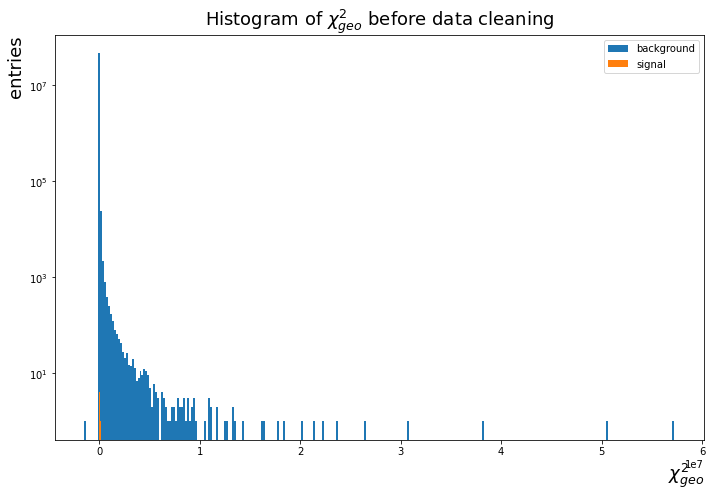

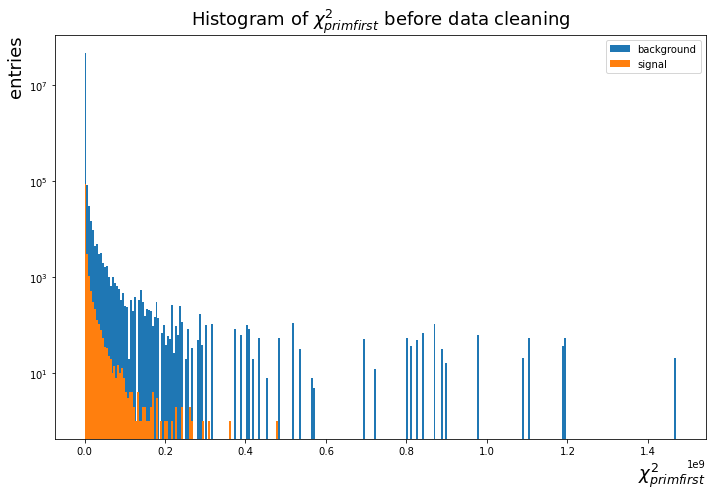

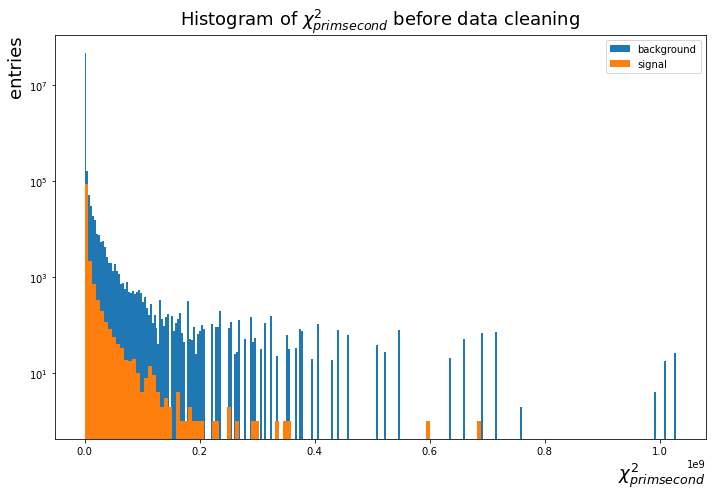

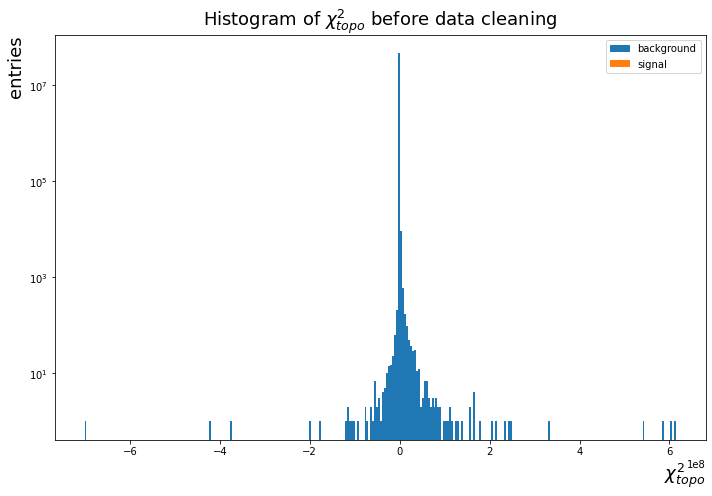

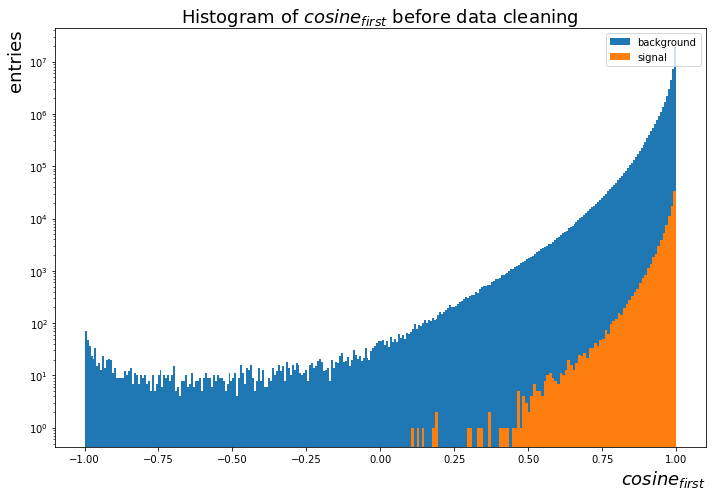

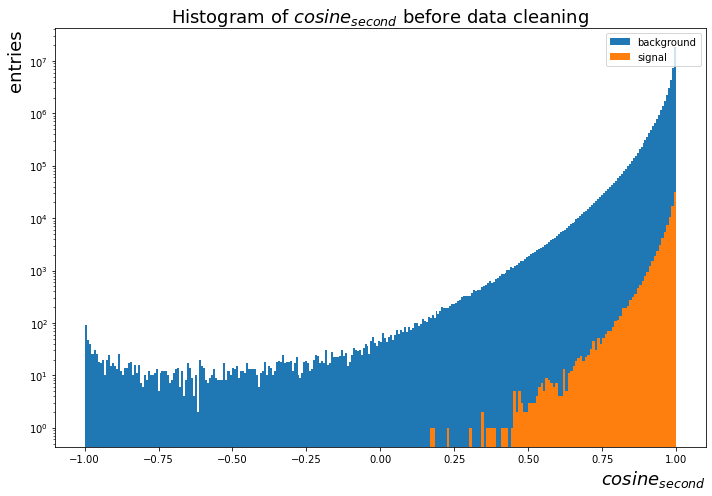

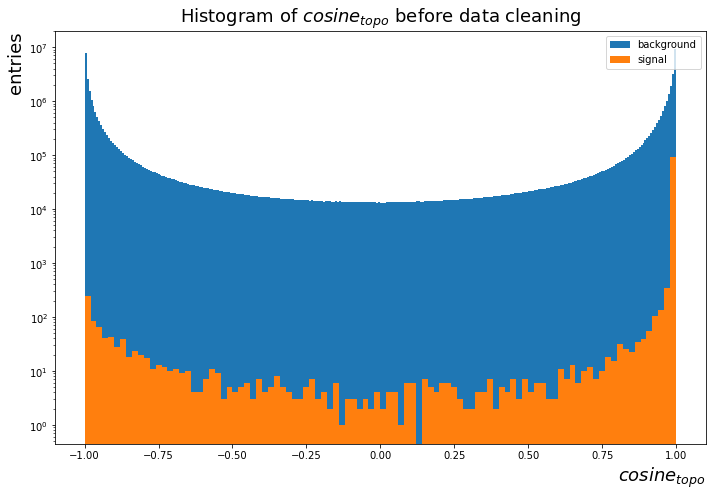

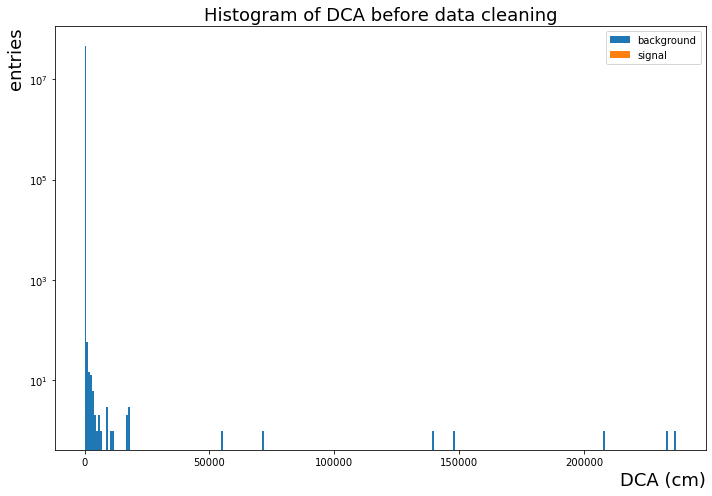

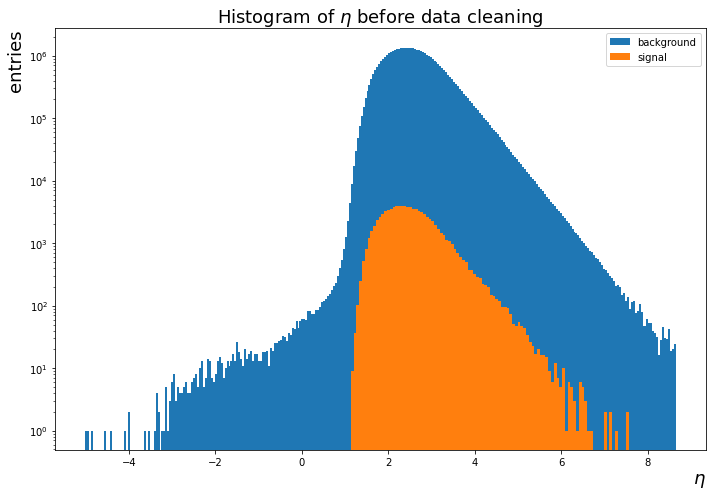

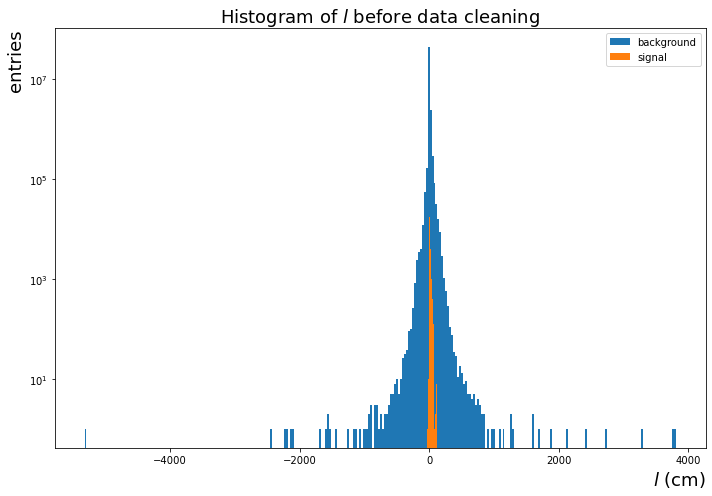

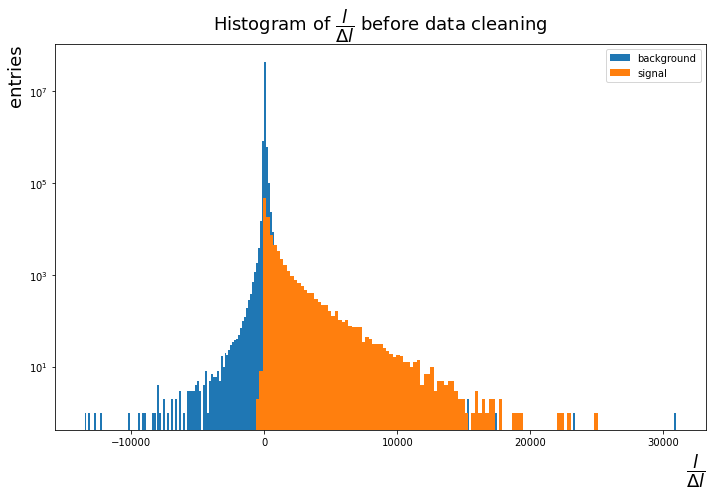

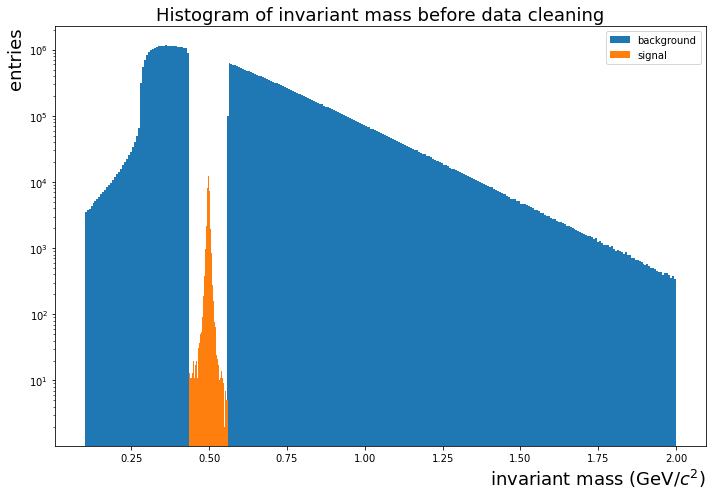

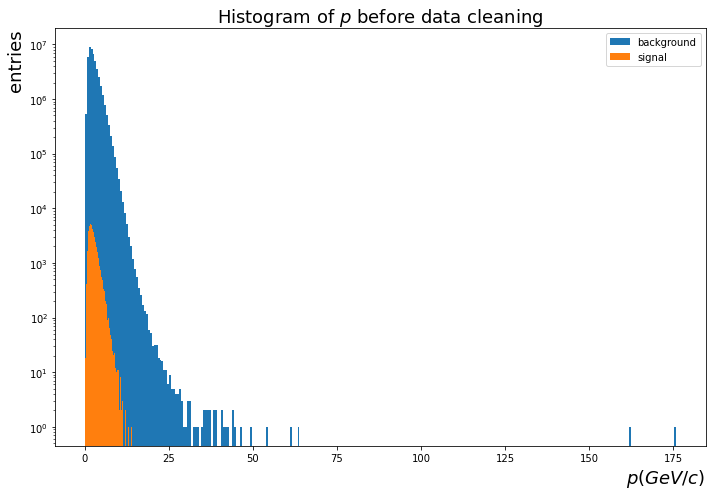

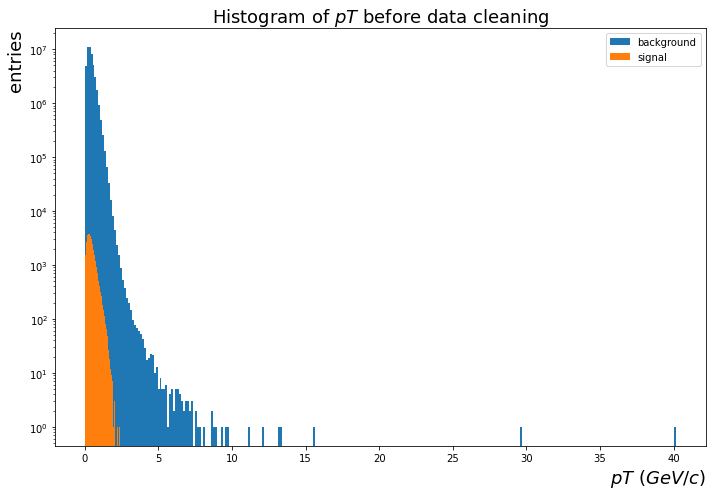

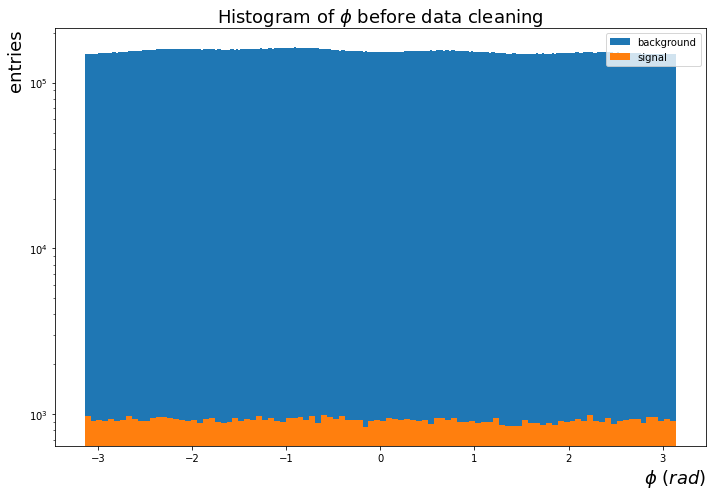

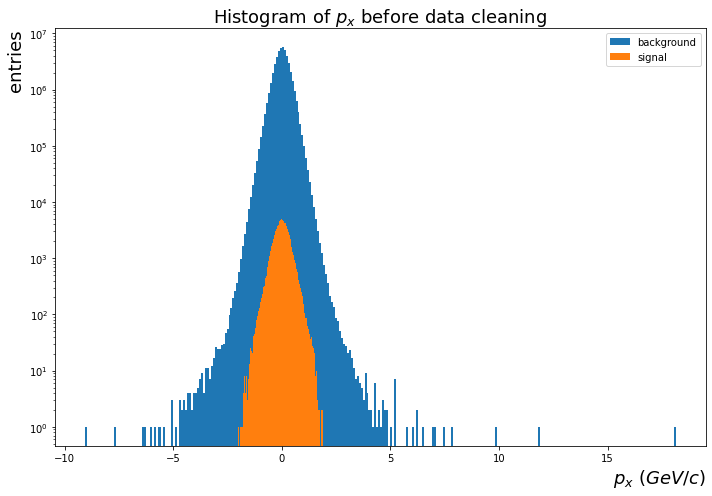

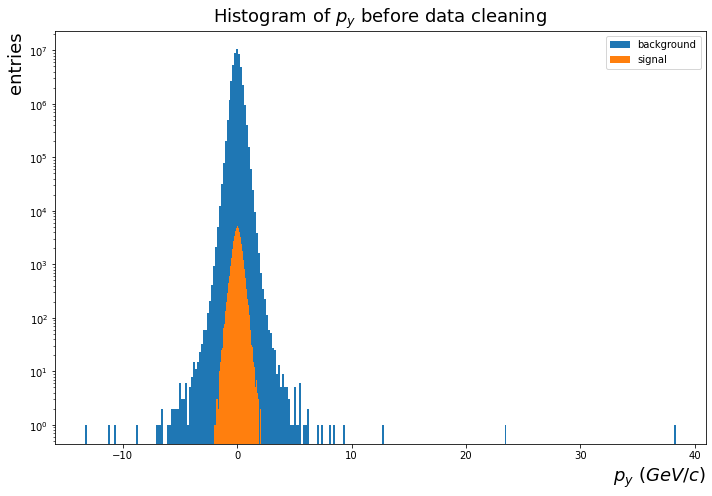

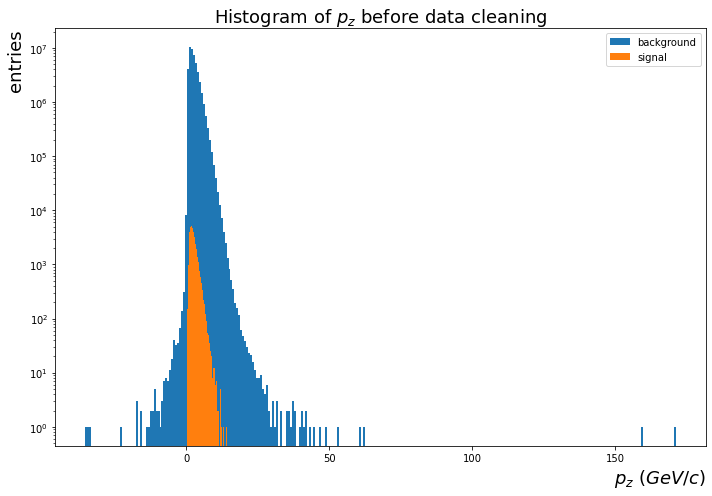

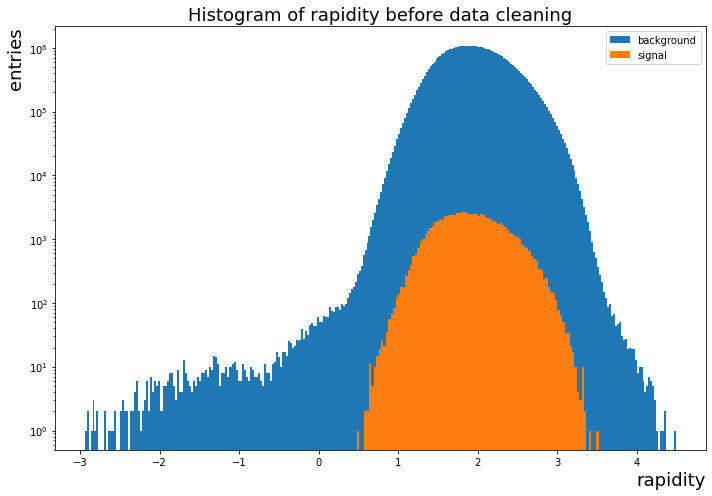

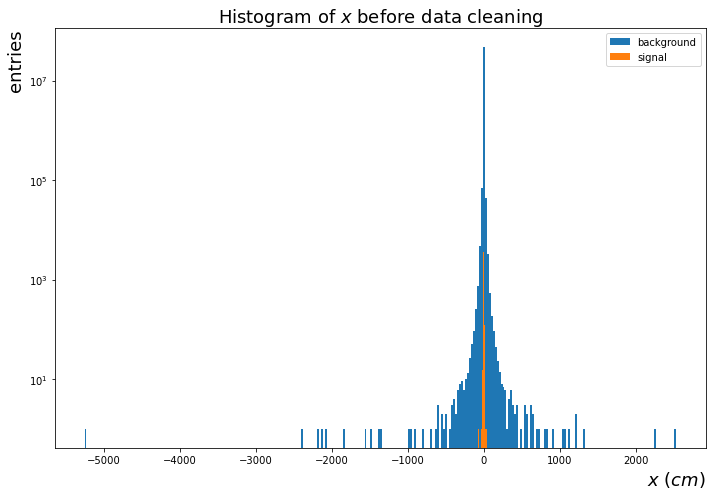

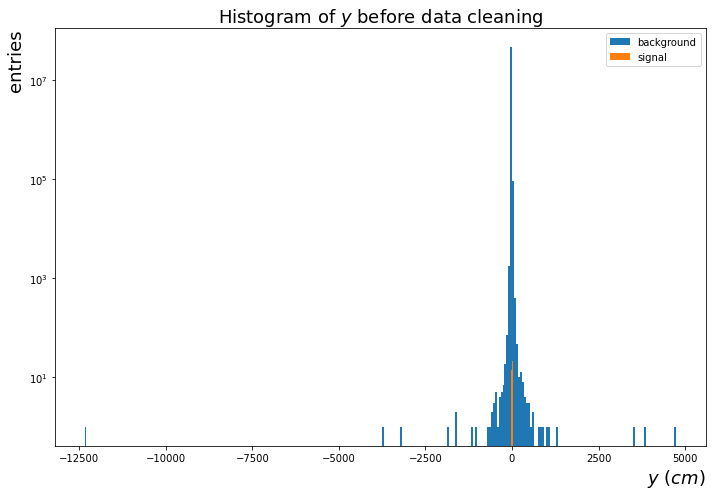

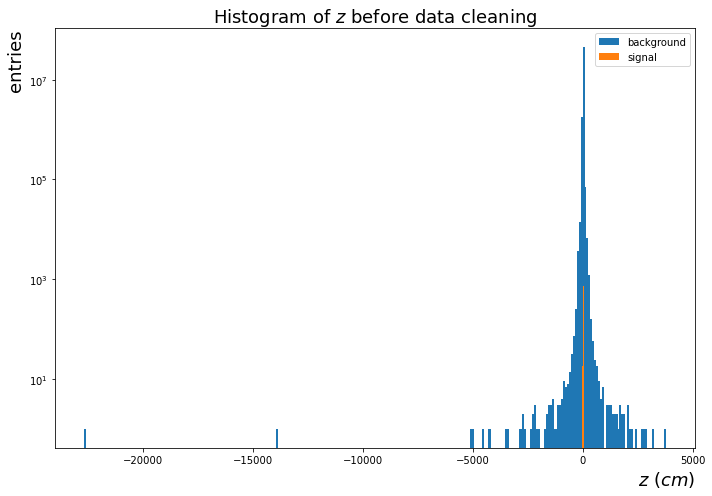

In [8]:
if not os.path.exists(directory+'img/histograms'):
    os.makedirs(directory+'img/histograms')
if not os.path.exists(directory+'img/histograms/before_cleaning'):
    os.makedirs(directory+'img/histograms/before_cleaning')
#we save all figures to pdf
pdf_beforeCleaning = PdfPages(directory+'img/histograms/histogramsBeforeCleaning.pdf') 
for i in sign.columns:
    fig, ax = plt.subplots(figsize=(10,7))
    name = names[sign.columns.get_loc(i)]
    xName = xNames[sign.columns.get_loc(i)]
    plt.title('Histogram of ' + name + ' before data cleaning', fontsize=18)
    plt.xlabel(xName, fontsize=18, loc='right')
    plt.ylabel("entries", fontsize=18, loc='top')
    plt.yscale('log')
    try:
        plt.hist(bckgr[i], bins =300, label='background')
        plt.hist(sign[i], bins=100, label='signal')
        plt.legend(loc='upper right')
        fig.tight_layout()
        fig.savefig(directory+"img/histograms/before_cleaning/"+ sign[i].name + ".png")
        fig.savefig(pdf_beforeCleaning,format='pdf')
    except ValueError:
        print('couldn\'t draw histogram (nan) for ' + name)
pdf_beforeCleaning.close()

713474

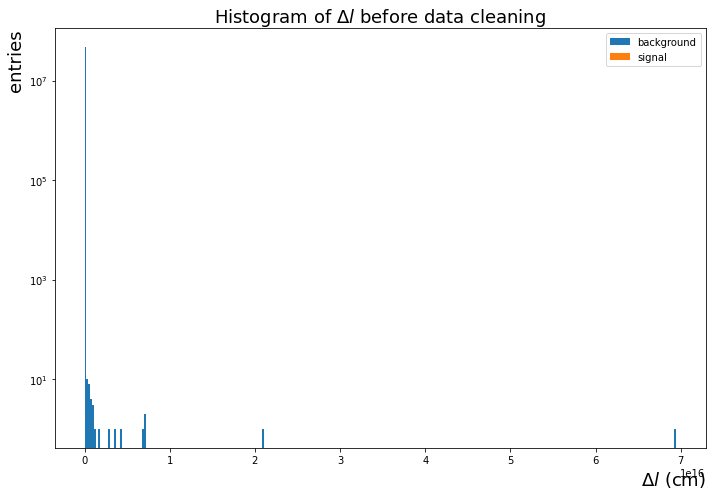

In [9]:
fig, ax = plt.subplots(figsize=(10,7))
name = r'$\Delta l$'
xName = r'$\Delta l$ (cm)'
plt.title('Histogram of ' + name + ' before data cleaning', fontsize=18)
plt.xlabel(xName, fontsize=18, loc='right')
plt.ylabel("entries", fontsize=18, loc='top')
plt.yscale('log')
try:
    plt.hist(bckgr['l']/bckgr['loverdl'], bins =300, label='background')
    plt.hist(sign['l']/sign['loverdl'], bins=300, label='signal')
    plt.legend(loc='upper right')
    fig.tight_layout()
    fig.savefig(directory+"img/histograms/before_cleaning/"+ name + ".png")
except ValueError:
    print('couldn\'t draw histogram (nan) for ' + name)
gc.collect()

28244

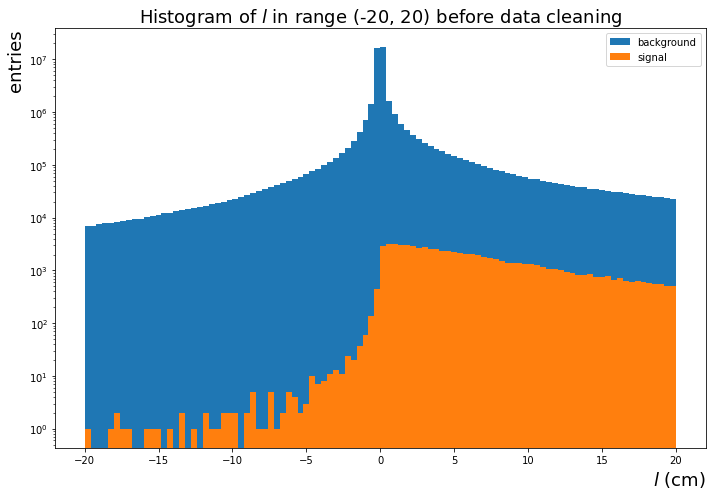

In [15]:
fig, ax = plt.subplots(figsize=(10,7))
name = r'$l$ in range (-20, 20)'
xName = r'$l$ (cm)'
plt.title('Histogram of ' + name + ' before data cleaning', fontsize=18)
plt.xlabel(xName, fontsize=18, loc='right')
plt.ylabel("entries", fontsize=18, loc='top')
plt.yscale('log')
try:
    plt.hist(bckgr['l'], bins =100, range=[-20, 20], label='background')
    plt.hist(sign['l'], bins=100, range=[-20, 20], label='signal')
    plt.legend(loc='upper right')
    fig.tight_layout()
    fig.savefig(directory+"img/histograms/before_cleaning/"+ name + ".png")
except ValueError:
    print('couldn\'t draw histogram (nan) for ' + name)
gc.collect()

29181

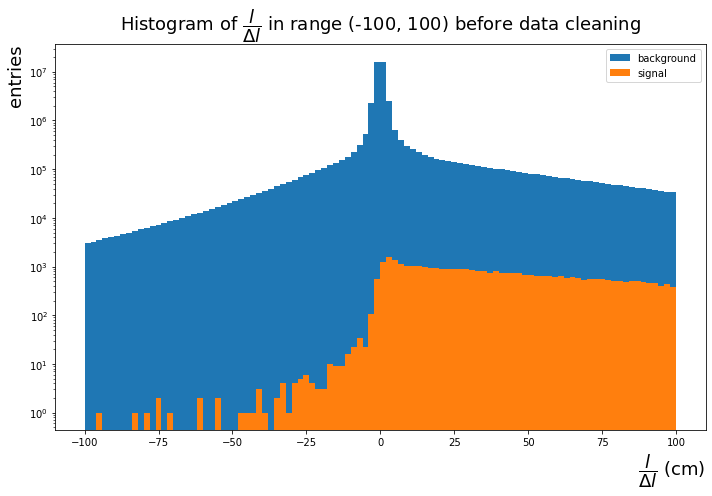

In [21]:
fig, ax = plt.subplots(figsize=(10,7))
name = r'$\dfrac{l}{\Delta l}$ in range (-100, 100)'
xName = r'$\dfrac{l}{\Delta l}$ (cm)'
plt.title('Histogram of ' + name + ' before data cleaning', fontsize=18)
plt.xlabel(xName, fontsize=18, loc='right')
plt.ylabel("entries", fontsize=18, loc='top')
plt.yscale('log')
try:
    plt.hist(bckgr['loverdl'], bins =100, range=[-100, 100], label='background')
    plt.hist(sign['loverdl'], bins=100, range=[-100, 100], label='signal')
    plt.legend(loc='upper right')
    fig.tight_layout()
    fig.savefig(directory+"img/histograms/before_cleaning/"+ name + ".png")
except ValueError:
    print('couldn\'t draw histogram (nan) for ' + name)
gc.collect()

# Data Cleaning
Sometimes a data set contains entries which are outliers or does not make sense. For example, infinite values or NaN entries. We clean the data by removing these entries. 

Similarly, CBM is a fixed target experiment so there are certain conditions which the data has to satisfy before it is considered as reliable data.So we apply certain limits on the data sets.

The values of these cuts are described: https://drive.google.com/file/d/1tb0FBRq4KgVu-VQZgpjA8ONbIGVCNOnE/view?usp=sharing https://github.com/julnow/JupyterNotebooks/blob/kaon/CBM%20K-short%20data%20cleaning.pdf

In [14]:
#CUTS USED FOR DATA CLEANING
#mass cuts for both bckgr and sign
lowerMassCut = 0.279
upperMassCut = 1.5
#distance cuts
#DCA
lowerDcaCut = 0
upperDcaCut = 100
#l distance
lowerLCut = -5
upperLCut = 80
#loverdl
lowerLdlCut = -25
upperLdlCut = 15000
#coordinate cuts
absXCut = 50
absYCut = 50
lowerZCut = -1
upperZCut = 80
#momentums cuts
pzLowerCut = 0
pUpperCut = 20
ptUpperCut = 3
#chi2
#geo
lowerChi2GeoCut = 0
upperChi2GeoCut = 10000
#topo
lowerChi2TopoCut = 0
upperChi2TopoCut = 100000
#prim first
lowerChi2PrimFirstCut = 0
upperChi2PrimFirstCut = 3e7
#prim second
lowerChi2PrimSecondCut = 0
upperChi2PrimSecondCut = 3e7
#pseudorapidity cuts
lowerEtaCut = 1.
upperEtaCut = 6.5

We'll also show how much data we loose with each type of cut

In [17]:
def clean_df(df):
    # let's treat all the infinite, inf, values by nan and then we drop all the null entries
    with pd.option_context('mode.use_inf_as_na', True):
        df = df.dropna()
    #Experimental constraints
    #momentum
    size_mom =  len(df[['pz', 'p', 'pT']])
    is_good_mom = (df['pz'] > pzLowerCut) & (df['p']<pUpperCut) & (df['pT']<ptUpperCut)
    percentage_mom = ( size_mom - len(df[is_good_mom]) ) / size_mom
    print('with the momentum selection criteria we lose we loose ' + str(round(percentage_mom*100, 4)) + '% of entries')
    #coordinates
    size_coord  =  len(df[['x', 'y', 'z']])
    is_good_coord = (abs(df['x']) < absXCut) & (abs(df['y']) < absYCut) & (df['z']>lowerZCut) & (df['z']<upperZCut)
    percentage_coord = ( size_coord - len(df[is_good_coord]) ) / size_coord
    print('with the coordinates selection criteria we lose we loose ' + str(round(percentage_coord*100, 2)) + '% of entries')
    #eta
    size_eta =  len(df[['eta']])
    is_good_eta = (df['eta']>lowerEtaCut) & (df['eta']<upperEtaCut)
    percentage_eta = ( size_eta - len(df[is_good_eta]) ) / size_eta
    print('with the pseudorapidity selection criteria we lose we loose ' + str(round(percentage_eta*100, 3)) + '% of entries')
    #DCA
    size_distance =  len(df[['distance']])
    is_good_distance = (df['distance'] > lowerDcaCut) & (df['distance'] < upperDcaCut) 
    percentage_distance = ( size_distance - len(df[is_good_distance]) ) / size_distance
    print('with the DCA selection criteria we lose we loose ' + str(round(percentage_distance*100, 3)) + '% of entries')
    #l and loverld
    size_l =  len(df[['l', 'loverdl']])
    is_good_l = (df['l']>lowerLCut) & (df['l']<upperLCut) & (df['loverdl']>lowerLdlCut) & (df['loverdl']<upperLdlCut)
    percentage_l = ( size_l - len(df[is_good_l]) ) / size_l
    print('with the l and loverdl selection criteria we lose we loose ' + str(round(percentage_l*100, 2)) + '% of entries')
    #chi2 geo and topo
    size_chi2geo_topo =  len(df[['chi2geo', 'chi2topo']])
    is_good_chi2geo_topo = (df['chi2geo']>lowerChi2GeoCut) & (df['chi2geo'] < upperChi2GeoCut) & (df['chi2topo'] > lowerChi2TopoCut) & (df['chi2topo'] < upperChi2TopoCut) 
    percentage_chi2geo_topo = ( size_chi2geo_topo - len(df[is_good_chi2geo_topo]) ) / size_chi2geo_topo
    print('with the chi^2 geo and topo selection criteria we lose we loose ' + str(round(percentage_chi2geo_topo*100, 2)) + '% of entries')
    #chi^2 prim
    size_daughters =  len(df[['chi2primfirst', 'chi2primsecond']])
    is_good_daughters = (df['chi2primfirst']>lowerChi2PrimFirstCut) & (df['chi2primfirst'] < upperChi2PrimSecondCut) & (df['chi2primsecond']>lowerChi2PrimSecondCut) & (df['chi2primsecond']<upperChi2PrimFirstCut)
    percentage_daughters = ( size_daughters - len(df[is_good_daughters]) ) / size_daughters
    print('with the chi^2 prim selection criteria we lose we loose ' + str(round(percentage_daughters*100, 2)) + '% of entries')
    #mass
    size_mass =  len(df[['mass']])
    is_good_mass = (df['mass']>lowerMassCut) & (df['mass']<upperMassCut)
    percentage_mass = ( size_mass - len(df[is_good_mass]) ) / size_mass
    print('with the mass selection criteria we lose we loose ' + str(round(percentage_mass*100, 4)) + '% of entries')

    is_good_df = (is_good_mom) & (is_good_coord) & (is_good_eta) & (is_good_distance) & (is_good_l) & (is_good_chi2geo_topo) & (is_good_daughters) & (is_good_mass) 

    return df[is_good_df]

In [18]:
#we'll count how much data we loose
bckgrCount = len(bckgr)
signCount = len(sign)
#we return to normal names while cleaning data
print('for background: ')
background = clean_df(bckgr)
print('\nfor signal: ')
signal = clean_df(sign)
backgroundCount = len(background)
signalCount = len(signal)
#lets count how much data we lose
backgroundDifference = bckgrCount-backgroundCount
signalDifference = signCount-signalCount
percentageBg = backgroundDifference/bckgrCount*100
percentageSg = signalDifference/signCount*100
#finally
print('\nwe lost ' + str(backgroundDifference)+' background entries (' + str(round(percentageBg, 2)) + '%) and ' + str(signalDifference) + ' signal entries (' + str(round(percentageSg)) + '%)')
gc.collect()

for background: 
with the momentum selection criteria we lose we loose 0.0123% of entries
with the coordinates selection criteria we lose we loose 6.69% of entries
with the pseudorapidity selection criteria we lose we loose 0.035% of entries
with the DCA selection criteria we lose we loose 0.018% of entries
with the l and loverdl selection criteria we lose we loose 3.97% of entries
with the chi^2 geo and topo selection criteria we lose we loose 2.63% of entries
with the chi^2 prim selection criteria we lose we loose 0.15% of entries
with the mass selection criteria we lose we loose 2.1093% of entries

for signal: 
with the momentum selection criteria we lose we loose 0.0% of entries
with the coordinates selection criteria we lose we loose 0.29% of entries
with the pseudorapidity selection criteria we lose we loose 0.016% of entries
with the DCA selection criteria we lose we loose 0.0% of entries
with the l and loverdl selection criteria we lose we loose 0.16% of entries
with the chi^2 

0

We see, date about 50% of the background entries and 3% of the signal entries were removed in this process

Let's create the histograms again, now after data cleaning. The cuts values are saved as variables and shown in the histograms

In [19]:
#cuts names to show on graphs after cuts
cutNames=[str(lowerChi2GeoCut)+' < $\chi^2_{geo}$ < '+str(upperChi2GeoCut), 
          str(lowerChi2PrimFirstCut)+' < $\chi^2_{prim first}$ < '+str(upperChi2PrimFirstCut),
          str(lowerChi2PrimSecondCut)+' < $\chi^2_{prim second}$ < '+str(upperChi2PrimFirstCut), 
          str(lowerChi2TopoCut)+' < $\chi^2_{topo}$ < '+str(upperChi2TopoCut),
          'no cuts',
          'no cuts',
          'no cuts',
          'no cuts',
          str(lowerEtaCut)+' < $\eta$ < '+str(upperEtaCut),
          str(lowerLCut)+' < $l$ < '+str(upperLCut),
          str(lowerLdlCut)+' < $\dfrac{l}{\Delta l}$ < '+str(upperLdlCut),
          str(lowerMassCut)+' < invariant mass < '+str(upperMassCut),
          '$p$ < '+str(pUpperCut),
          '$pT$ < '+str(ptUpperCut),
          'no cuts',
          'no cuts',
          'no cuts',
          str(pzLowerCut)+' < $p_z$ ',
          'no cuts',
          '$|x|$ < '+str(absXCut),
          '$|y|$ < '+str(absYCut),
          str(lowerZCut)+' < $z$ < '+str(upperZCut),    
]

In [ ]:
if not os.path.exists(directory+'img/histograms/after_cleaning'):
    os.makedirs(directory+'img/histograms/after_cleaning')
pdf_afterCleaning = PdfPages(directory+'img/histograms/histogramsAfterCleaning.pdf') 
for i in signal.columns:
    fig, ax = plt.subplots(figsize=(10,7))
    name = names[signal.columns.get_loc(i)]
    xName = xNames[signal.columns.get_loc(i)]
    cutName = cutNames[signal.columns.get_loc(i)]
    plt.title('Histogram of ' + name + ' after data cleaning', fontsize=18)
    plt.xlabel(xName, fontsize=18, loc='right')
    plt.ylabel("entries", fontsize=18, loc='top')
    plt.yscale('log')
    ##########coordinates for box with cuts info
    plt.annotate(cutName, xy=(0.1, 0.9), xycoords='axes fraction',
        fontsize = 14, bbox = dict(alpha = 0.5))
    ###########
    try:
        plt.hist(background[i], bins =300, label='background')
        plt.hist(signal[i], bins=300, label='signal')
        plt.legend(loc='upper right')
        fig.tight_layout()
        fig.savefig(directory+"img/histograms/after_cleaning/"+ signal[i].name + ".png")
        plt.savefig(pdf_afterCleaning,format='pdf')
    except ValueError:
        print('couldn\'t draw histogram (nan) for ' + name)
pdf_afterCleaning.close()
gc.collect()

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
name = r'$\dfrac{l}{\Delta l}$ in range (-25, 100)'
xName = r'$\dfrac{l}{\Delta l}$ (cm)'
plt.title('Histogram of ' + name + ' after data cleaning', fontsize=18)
plt.xlabel(xName, fontsize=18, loc='right')
plt.ylabel("entries", fontsize=18, loc='top')
plt.yscale('log')
try:
    plt.hist(bckgr['loverdl'], bins =100, range=[-25, 100], label='background')
    plt.hist(sign['loverdl'], bins=100, range=[-25, 100], label='signal')
    plt.legend(loc='upper right')
    fig.tight_layout()
    fig.savefig(directory+"img/histograms/after_cleaning/"+ name + ".png")
except ValueError:
    print('couldn\'t draw histogram (nan) for ' + name)
gc.collect()

42454

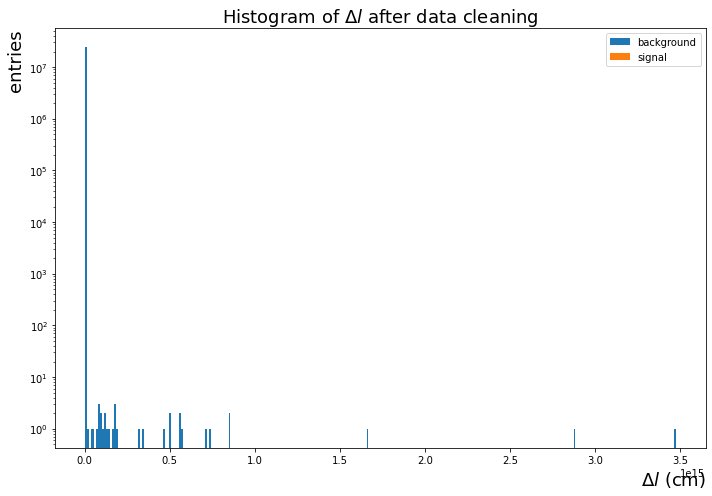

In [17]:
#histogram of delta l (division between l and loverdl)
fig, ax = plt.subplots(figsize=(10,7))
name = r'$\Delta l$'
xName = r'$\Delta l$ (cm)'
plt.title('Histogram of ' + name + ' after data cleaning', fontsize=18)
plt.xlabel(xName, fontsize=18, loc='right')
plt.ylabel("entries", fontsize=18, loc='top')
plt.yscale('log')
try:
    plt.hist(background['l']/background['loverdl'], bins =300, label='background')
    plt.hist(signal['l']/signal['loverdl'], bins=300, label='signal')
    plt.legend(loc='upper right')
    fig.tight_layout()
    fig.savefig(directory+"img/histograms/after_cleaning/"+ name + ".png")
except ValueError:
    print('couldn\'t draw histogram (nan) for ' + name)
gc.collect()

33403

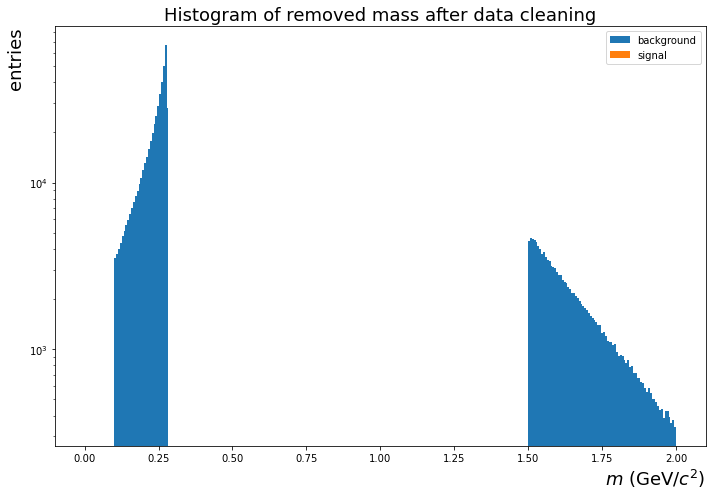

In [95]:
#difference between mass before and after cut
is_good_bckgr_mass = (bckgr['mass']>lowerMassCut) & (bckgr['mass']<upperMassCut)
is_good_sign_mass = (sign['mass']>lowerMassCut) & (sign['mass']<upperMassCut)
fig, ax = plt.subplots(figsize=(10,7))
name = 'diff_mass'
xName = r'$m$ (GeV/$c^2$)'
plt.title('Histogram of removed mass after data cleaning', fontsize=18)
plt.xlabel(xName, fontsize=18, loc='right')
plt.ylabel("entries", fontsize=18, loc='top')
plt.yscale('log')
try:
    plt.hist(bckgr[~is_good_bckgr_mass]['mass'], bins =300, label='background')
    plt.hist(sign[~is_good_sign_mass]['mass'], bins=100, label='signal')
    plt.legend(loc='upper right')
    fig.tight_layout()
    fig.savefig(directory+"img/histograms/after_cleaning/"+ name + ".png")
except ValueError:
    print('couldn\'t draw histogram (nan) for ' + name)
gc.collect()

29843

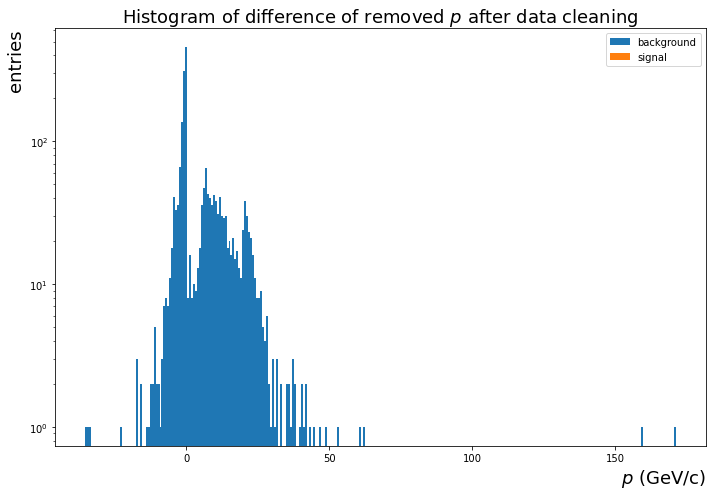

In [96]:
#difference between p before and after cut
is_good_bckgr_mom = (bckgr['pz'] > pzLowerCut) & (bckgr['p']<pUpperCut) & (bckgr['pT']<ptUpperCut)
is_good_sign_mom = (sign['pz'] > pzLowerCut) & (sign['p']<pUpperCut) & (sign['pT']<ptUpperCut)
fig, ax = plt.subplots(figsize=(10,7))
name = 'diff_p'
xName = r'$p$ (GeV/c)'
plt.title('Histogram of difference of removed $p$ after data cleaning', fontsize=18)
plt.xlabel(xName, fontsize=18, loc='right')
plt.ylabel("entries", fontsize=18, loc='top')
plt.yscale('log')
try:
    plt.hist(bckgr[~is_good_bckgr_mom]['pz'], bins =300, label='background')
    plt.hist(sign[~is_good_sign_mom]['pz'], bins=100, label='signal')
    plt.legend(loc='upper right')
    fig.tight_layout()
    fig.savefig(directory+"img/histograms/after_cleaning/"+ name + ".png")
except ValueError:
    print('couldn\'t draw histogram (nan) for ' + name)
gc.collect()

31844

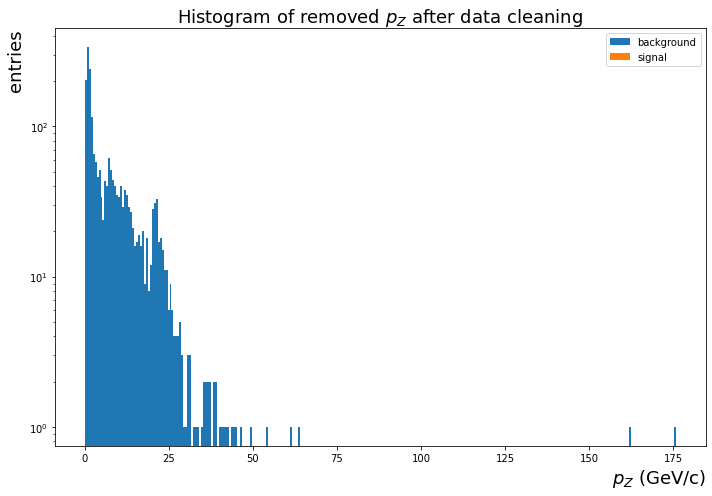

In [97]:
#difference between p before and after cut
is_good_bckgr_mom = (bckgr['pz'] > pzLowerCut) & (bckgr['p']<pUpperCut) & (bckgr['pT']<ptUpperCut)
is_good_sign_mom = (sign['pz'] > pzLowerCut) & (sign['p']<pUpperCut) & (sign['pT']<ptUpperCut)
fig, ax = plt.subplots(figsize=(10,7))
name = 'diff_pz'
xName = r'$p_Z$ (GeV/c)'
plt.title('Histogram of removed $p_Z$ after data cleaning', fontsize=18)
plt.xlabel(xName, fontsize=18, loc='right')
plt.ylabel("entries", fontsize=18, loc='top')
plt.yscale('log')
try:
    plt.hist(bckgr[~is_good_bckgr_mom]['p'], bins =300, label='background')
    plt.hist(sign[~is_good_sign_mom]['p'], bins=100, label='signal')
    plt.legend(loc='upper right')
    fig.tight_layout()
    fig.savefig(directory+"img/histograms/after_cleaning/"+ name + ".png")
except ValueError:
    print('couldn\'t draw histogram (nan) for ' + name)
gc.collect()

we also merge the two pdf with histograms with command: 

# Correlation
We find the correlation of all variables with signal and background candidates. We use the pearson correlation coefficient (linear correlation) for our analysis. It is defined as 
$$
\rho = \frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
$$
Here, COV(X,Y) is the covariance of the variable X and Y, and $\sigma_X$ and $\sigma_Y$ are the standard deviations of the variables. Pearson co-efficient is useful for linear correlation but it fails to take into account outliers and non-linear correlation. $\rho \> 0$ means postive while the opposite means negative correlation between two variables. 

This correlation function comes in built in the pandas library so we are using it. This function can also find other non-linear correlation coefficients like kendall and spearman. 

In [20]:
variables_to_draw = ['chi2geo', 'chi2primfirst', 'chi2primsecond', 'chi2topo', 'cosinefirst',
       'cosinesecond', 'cosinetopo', 'distance', 'eta', 'l', 'loverdl',
       'mass', 'p', 'pT', 'phi', 'px', 'py', 'pz', 'rapidity']

In [28]:
if not os.path.exists(directory+'img/correlations'):
    os.makedirs(directory+'img/correlations')
def correlation_graph(df, variables, title):
    # The variables pid, isfrompv and issignal are not that much varying so we remove them
    new_df = df[variables]
    # Using the pandas correlation function corr we find the correlation
    df_correlation_all = new_df.corr(method='pearson')
    
    #The cosmetics of the graph
    fig, ax = plt.subplots(figsize=(20,15))  #figure size
    cmap = sn.diverging_palette(240, 10, as_cmap=True, n=200) #color map
    cax = sn.heatmap(df_correlation_all, annot=True,cbar_kws={"shrink": .5},  cmap=cmap,  vmin=-1, vmax=1, 
                 center=0)
    ax.set_xticks(np.arange(0, len(df_correlation_all.columns), step=1))
    ax.set_xticklabels(df_correlation_all.columns, fontsize=15, rotation =70)
    ax.set_yticklabels(df_correlation_all.columns, fontsize=15)
    ax.set_title(title, fontsize = 20)
    fig.tight_layout()
    fig.savefig(directory+'img/correlations/'+title.replace(' ', '_')+'.pdf')
    fig.savefig(directory+'img/correlations/'+title.replace(' ', '_')+'.png')

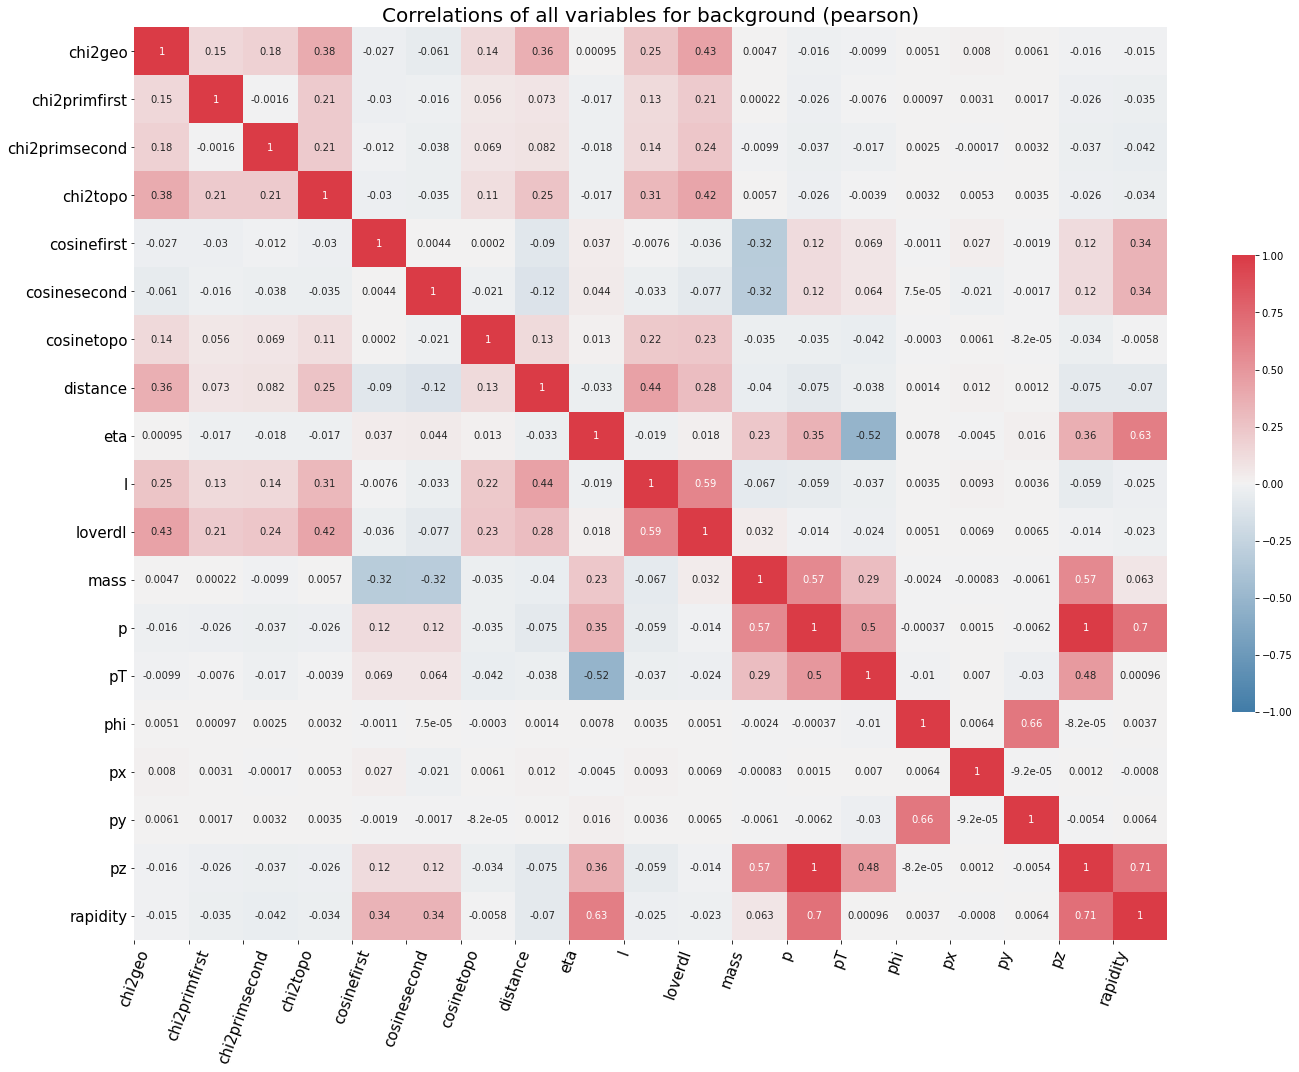

In [29]:
#correlation graph for background
correlation_graph(background, variables_to_draw, 'Correlations of all variables for background (pearson)')

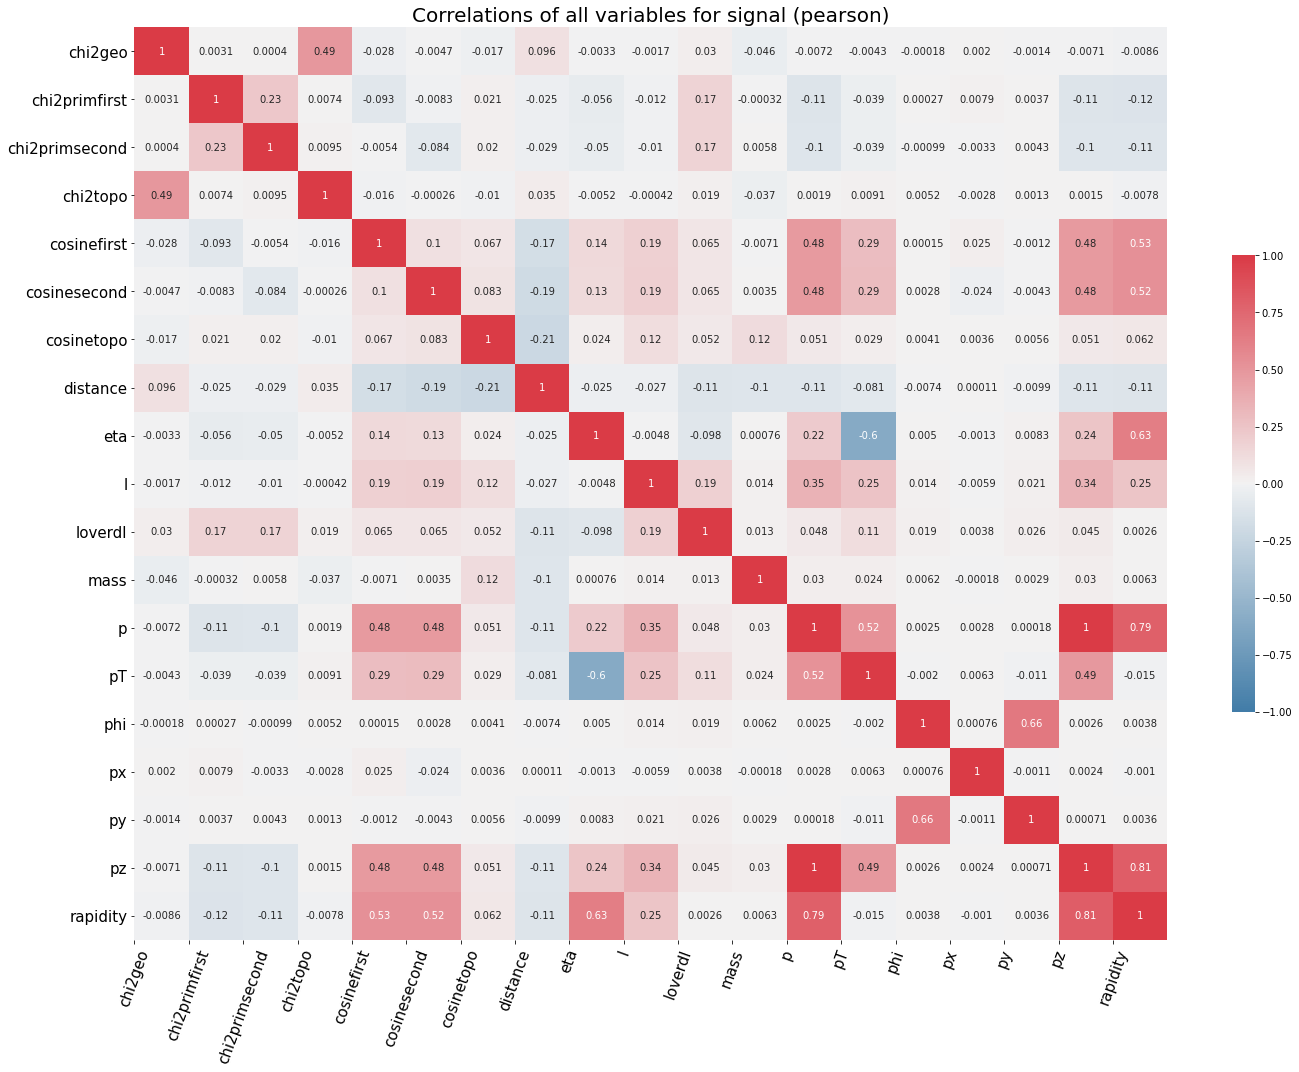

In [30]:
#correlation graph for signal
correlation_graph(sign, variables_to_draw, 'Correlations of all variables for signal (pearson)')

The correlation graph of the background variables shows that: cosinefirst, cosinesecond, $p_T$, $p_z$, and $p$ is correlated with mass. To check whether it is a real correlation or a statistical fluctuation we make our own correlation function. 

## Correlations by formula
The following function calculates the correlation along with the standard error of the mean (SEM) of the input variable with all the other variables. The standard error of the mean is defined as $ SEM = \frac{\sigma}{\sqrt{n}}$. Here $\sigma$ is the standard deviation of a variable. It will put error bars on each bin.

The function accepts 3 variables, a data frame object in the first input, a list of strings to be correlated with the third input (a string).

In [31]:
def calculate_correlation(df, vars_to_corr, target_var) :

    from scipy.stats import sem

    mean = df[target_var].mean()
    sigma = df[target_var].std()

    correlation = []
    error = []

    for j in vars_to_corr :
        mean_j = df[j].mean()
        sigma_j = df[j].std()
        if (sigma) and (sigma_j) != 0:
            cov = ((df[j] - mean_j) * (df[target_var] - mean)).mean() / (sigma*sigma_j)
            correlation.append(cov)
            error.append(sem(cov))
        else:
            print(str(vars_to_corr) + 'can\'t be calculated, sigma: ' + str(sigma) +' , sigma_j: ' +str(sigma_j))

    return correlation, error

In [32]:
# Provide the data frame object first, then also inside the brackets of list and then write the variable inside inverted commas ''.
# For signal
corr_signal, corr_signal_errors = calculate_correlation(signal, list(signal), 'mass')
# For background
corr_bg, corr_bg_errors = calculate_correlation(background, list(background), 'mass')

/opt/homebrew/Caskroom/miniforge/base/envs/cbm21/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/Caskroom/miniforge/base/envs/cbm21/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


/opt/homebrew/Caskroom/miniforge/base/envs/cbm21/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/var/folders/_8/1pnnpyz111s3q4bf02xypbgc0000gn/T/ipykernel_996/2424351059.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(signal.columns, fontsize=15, rotation =90)


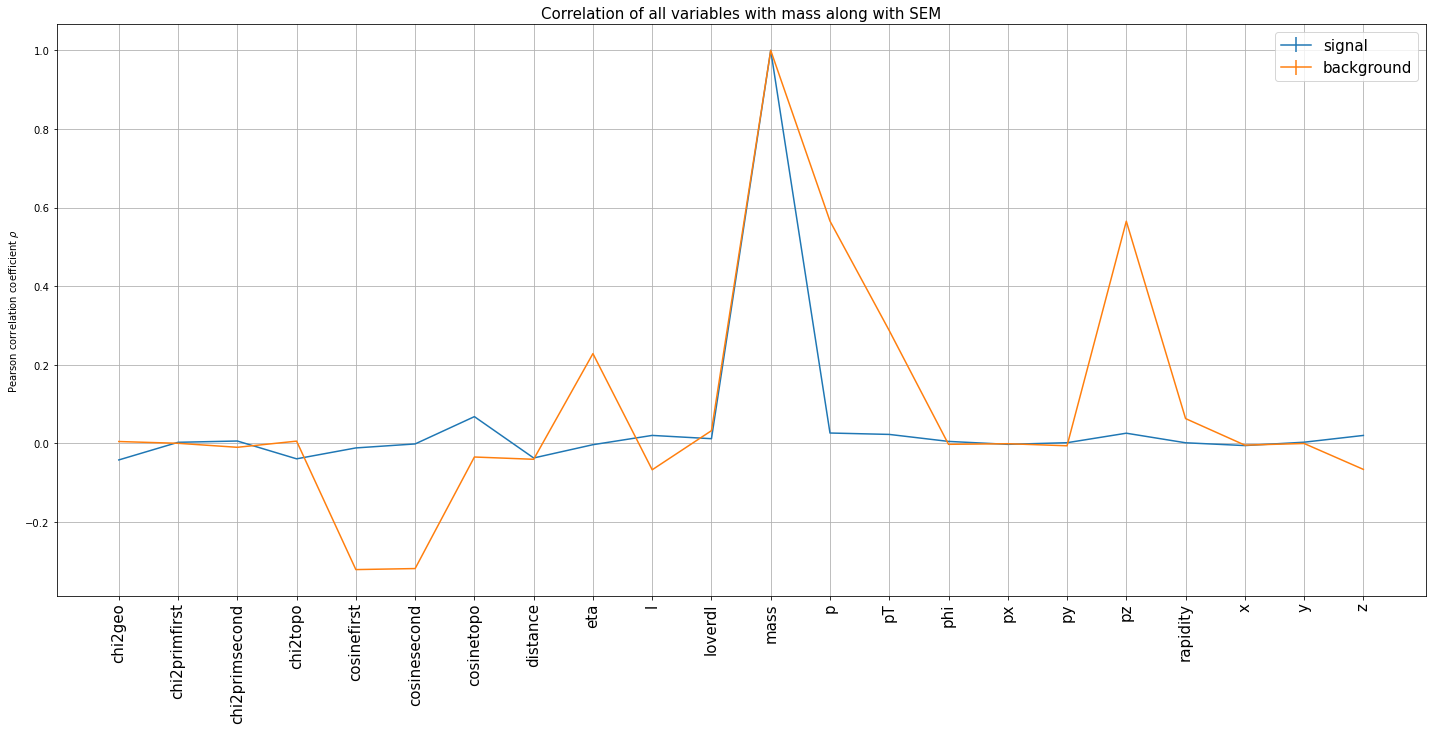

In [33]:
# Plotting the correlations of various variables with mass along with the errors
fig, ax = plt.subplots(figsize=(20,10))
plt.errorbar(list(signal), corr_signal, yerr=corr_signal_errors, fmt='')
plt.errorbar(list(background), corr_bg, yerr=corr_bg_errors, fmt='')
ax.grid(zorder=0)
ax.set_ylabel('Pearson correlation coefficient $\\rho$')
ax.set_xticklabels(signal.columns, fontsize=15, rotation =90)
plt.legend(('signal','background'), fontsize = 15)
plt.tight_layout()
title = 'Correlation of all variables with mass along with SEM'
plt.title(title, fontsize = 15)
fig.savefig(directory+'img/correlations/'+title.replace(' ', '_')+'.png', bbox_inches='tight')
fig.savefig(directory+'img/correlations/'+title.replace(' ', '_')+'.pdf', bbox_inches='tight')

In [34]:
#mean based correlation
def calculate_correlation1(df, vars_to_corr, target_var) :

    from scipy.stats import sem

    mean = df[target_var].mean()
    sigma = df[target_var].std()

    correlation = []
    error = []

    for j in vars_to_corr :
        mean_j = df[j].mean()
        sigma_j = df[j].std()
        if (sigma) and (sigma_j) != 0:
            cov = ((df[j] - mean_j) * (df[target_var] - mean)).mean() / (mean*mean_j)
            correlation.append(cov)
            error.append(sem(cov))
        else:
            print(str(vars_to_corr) + 'can\'t be calculated, sigma: ' + str(sigma) +' , sigma_j: ' +str(sigma_j))

    return correlation, error

In [35]:
# Provide the data frame object first, then also inside the brackets of list and then write the variable inside inverted commas ''.
# For signal
corr_signal1, corr_signal_errors1 = calculate_correlation1(signal, list(signal), 'mass')
# For background
corr_bg1, corr_bg_errors1 = calculate_correlation1(background, list(background), 'mass')

/opt/homebrew/Caskroom/miniforge/base/envs/cbm21/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/Caskroom/miniforge/base/envs/cbm21/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


/opt/homebrew/Caskroom/miniforge/base/envs/cbm21/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/var/folders/_8/1pnnpyz111s3q4bf02xypbgc0000gn/T/ipykernel_996/1953178456.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(signal.columns, fontsize=15, rotation =90)


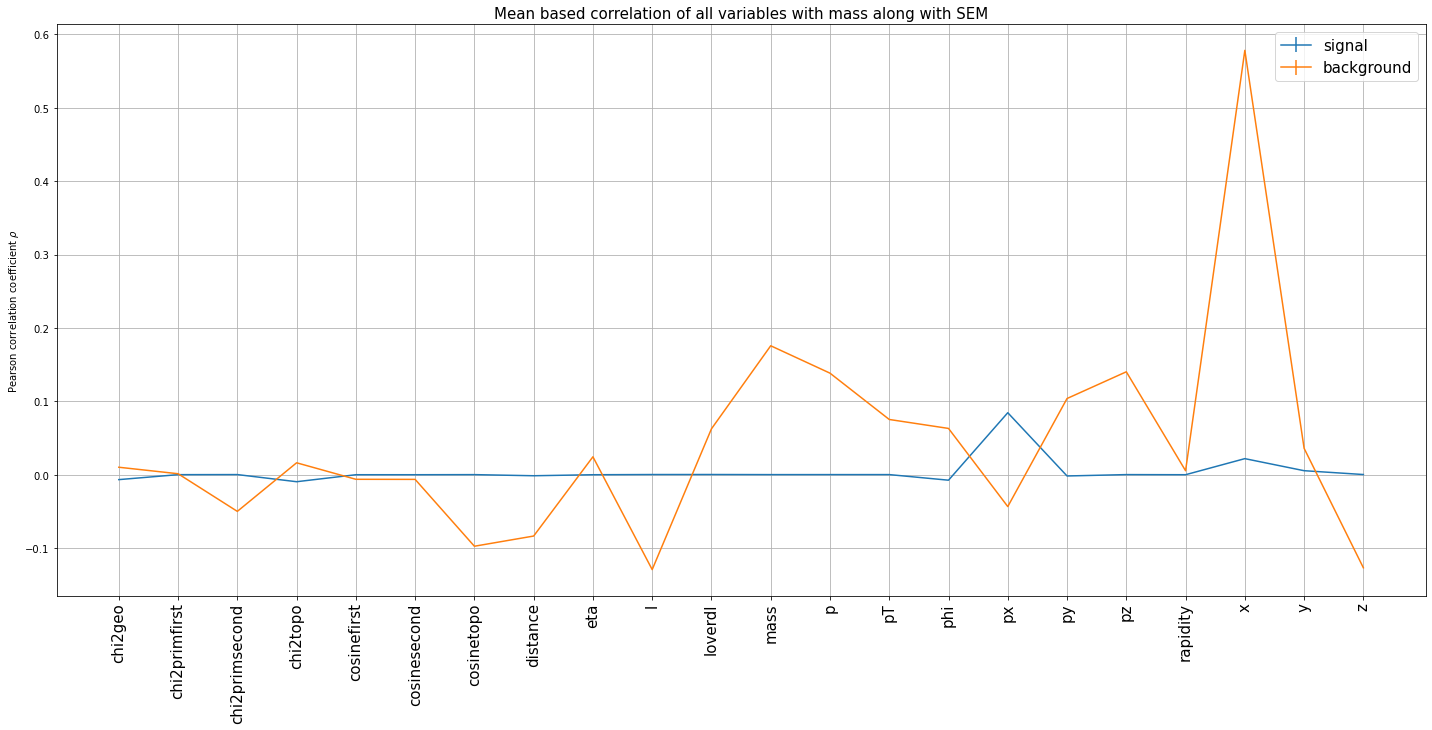

In [36]:
# Plotting the correlations of various variables with mass along with the errors
fig, ax = plt.subplots(figsize=(20,10))
plt.errorbar(list(signal), corr_signal1, yerr=corr_signal_errors1, fmt='')
plt.errorbar(list(background), corr_bg1, yerr=corr_bg_errors1, fmt='')
ax.grid(zorder=0)
ax.set_ylabel('Pearson correlation coefficient $\\rho$')
ax.set_xticklabels(signal.columns, fontsize=15, rotation =90)
plt.legend(('signal','background'), fontsize = 15)
plt.tight_layout()
title = 'Mean based correlation of all variables with mass along with SEM'
plt.title(title, fontsize = 15)
fig.savefig(directory+'img/correlations/'+title.replace(' ', '_')+'.png', bbox_inches='tight')
fig.savefig(directory+'img/correlations/'+title.replace(' ', '_')+'.pdf', bbox_inches='tight')

We'll take a closer look at the correlations between the mass and: pseudorapidity, cosinecut, pT, pz and p in the pt 2 notebook <link>